In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
from pprint import pprint


from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, classification_report,confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeRegressor,export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin



from datetime import datetime,timedelta

import os
import json

#Snowflake
import sqlalchemy
import sqlalchemy.dialects.sqlite
from snowflake.sqlalchemy import URL

from IPython.display import display, HTML, Image
from subprocess import call
import gc
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

In [2]:
gc.collect()

31

In [3]:
config_file = os.path.join(os.environ['HOME'], '.snowflake_creds.json')
with open(config_file,'r') as f:
    snowflake_creds = json.load(f)

engine = sqlalchemy.create_engine(
     URL(
         account = snowflake_creds["account"],
         user = snowflake_creds["user"],
         password = snowflake_creds["password"],
         database = snowflake_creds["database"],
         schema = 'aib',
         warehouse = 'DS',
         role = 'DS',
         numpy=True             
     )
)
connection = engine.connect()

In [4]:
class ColumnSelector(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[self.cols]

    def fit(self, X, y=None):
        return self

    def get_feature_names(self):
        return X[self.cols].columns.tolist()

class CategoricalColumnSelector(TransformerMixin):
    def __init__(self,feats):
        self.feats = feats

    def transform(self, X, y=None):
        regstr = ''
        length = len(self.feats)
        for i,feat in enumerate(self.feats):
            regstr = regstr+'^'+feat+'_+'

            if i < length-1:
                regstr = regstr+'|'
        return X.filter(regex=regstr)

    def fit(self, X, y=None):
        return self

    def get_feature_names(self):
        return X[self.cols].columns.tolist()

class ToSparse(TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, y=None):
        return sparse.csr_matrix(X)

    def fit(self, X, y=None):
        return self


In [5]:
def build_dummies(dataframe,feats):
    df = pd.DataFrame()
    for feat in feats:
        df = pd.concat([df,pd.get_dummies(dataframe[feat],prefix=feat)],axis=1,sort=False)
    df = pd.concat([dataframe,df],axis=1,sort=False)
    df.drop(feats,axis=1,inplace=True)
    return df

def convert_string(column):
    return column.apply(lambda x: str(int(x)) if not pd.isnull(x) else 'Empty')

def best_params(grid):
    estimator = grid.best_estimator_
    pca = grid.best_estimator_.steps[1][1]
    classifier = grid.best_estimator_.steps[2][1]
    params = grid.best_params_
    score = grid.best_score_
    return estimator,pca,classifier,params,score

In [6]:
def getUserDF(): 
    sql = """
    WITH traverse AS
    (
      SELECT traverse_ts::DATE AS send_date,
             email,
             COUNT(*) traverse_signal,
             SUM(CASE WHEN CONTAINS(split_part (category,'/',2),'education') THEN 1 ELSE 0 END) AS education_signal
      FROM ds_scratch.traverse_feature_collection
      WHERE traverse_ts::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
      AND email LIKE '%.com'
      GROUP BY 1,
               2
    ),
    clicks AS
    (
      SELECT click::DATE AS click_date,
             email,
             isp,
             COUNT(*) clicks
      FROM aib.clicks
      WHERE click::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
      GROUP BY 1,
               2,
               3
    ),
    year_clicks AS
    (
      SELECT send_date,
             t1.email,
             isp,
             SUM(clicks) OVER (
             PARTITION BY t1.email,isp,send_date
             ORDER BY click_date 
             ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_clicks
      FROM traverse AS t1
        LEFT JOIN clicks AS t2
               ON t1.email = t2.email
              AND t2.click_date <= send_date
    ),
    opens AS
    (
      SELECT opendt::DATE AS open_date,
             email,
             isp,
             COUNT(*) AS opens
      FROM aib.opens
      WHERE opendt::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
      GROUP BY 1,
               2,
               3
    ),
    year_opens AS
    (
      SELECT send_date,
             t1.email,
             isp,
             SUM(opens) OVER (
             PARTITION BY t1.email,isp,send_date
             ORDER BY open_date 
             ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_opens
      FROM traverse as t1
        LEFT JOIN opens AS t2
               ON t1.email = t2.email
              AND t2.open_date <= send_date
    ),
    year_signals AS
    (
      SELECT send_date,
             email,
             SUM(traverse_signal) OVER (
             PARTITION BY email,send_date
             ORDER BY send_date 
             ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_signals,
             SUM(education_signal) OVER (
             PARTITION BY email,send_date 
             ORDER BY send_date 
             ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS education_signals
      FROM traverse
    ),
    deploy_stats AS
    (
      SELECT DEPLOY_ID,
             SUM(NVL (INTERNAL_CLICKS,0) + NVL (AR_CLICKS,0)) AS clicks,
             SUM(NVL (REVENUE,0)) AS revenue
      FROM DS_PROD.SOURCE_CUBE
      GROUP BY 1
    ),
    epc AS
    (
      SELECT DEPLOY_ID,
             revenue / clicks AS epc
      FROM deploy_stats
      WHERE clicks != 0
    ),
    L30_sends AS
    (
      SELECT TRIM(JSON:email,'"') AS email,
             TRIM(JSON:isp,'"') AS isp,
             COUNT(*) AS L30_sends
      FROM aib.sends
      WHERE TIMESTAMP_REC::DATE BETWEEN CURRENT_DATE -31 AND CURRENT_DATE -1
      GROUP BY 1,
               2
    ),
    L30_clicks AS
    (
      SELECT email,
             isp,
             deploy_id,
             COUNT(*) AS L30_clicks
      FROM aib.clicks
      WHERE click::DATE BETWEEN CURRENT_DATE -31 AND CURRENT_DATE -1
      GROUP BY 1,
               2,
               3
    ),
    revenue AS
    (
      SELECT email,
             isp,
             SUM(L30_clicks*epc) AS l30_revenue
      FROM L30_clicks
        JOIN epc USING (deploy_id)
      GROUP BY 1,
               2
    ),
    click_stats AS
    (
      SELECT send_date,
             email,
             isp,
             MAX(total_clicks) AS clicks_to_date
      FROM year_clicks
      GROUP BY 1,
               2,
               3
    ),
    open_stats AS
    (
      SELECT send_date,
             email,
             isp,
             MAX(total_opens) AS opens_to_date
      FROM year_opens
      GROUP BY 1,
               2,
               3
    ),
    traverse_stats AS
    (
      SELECT send_date,
             email,
             MAX(total_signals) AS signals_to_date,
             MAX(education_signals) AS edu_signals_to_date
      FROM year_signals
      GROUP BY 1,
               2
    ),
    initial AS
    (
      SELECT send_date as recent_send,
             DATEDIFF(day,send_date,current_date+1) as days_from_next_send,
             current_date+1 as next_send,
             email,
             isp,
             clicks_to_date,
             opens_to_date,
             signals_to_date,
             edu_signals_to_date,
             l30_revenue,
             L30_sends,
             L30_revenue*1000.0 / L30_sends AS ecpm
      FROM traverse_stats
        LEFT JOIN click_stats USING (send_date,email)
        LEFT JOIN open_stats USING (send_date,email)
        LEFT JOIN l30_sends USING (email)
        LEFT JOIN revenue USING (email)
      WHERE L30_sends IS NOT NULL
      AND   L30_sends != 0
    ),
    first_names AS
    (
      SELECT DISTINCT email,
             FIRST_VALUE(first_name) IGNORE NULLS OVER (PARTITION BY email ORDER BY timestamp_rec DESC) AS first_name
      FROM aib.signup_actives
        JOIN DS_SCRATCH.recommender_targets USING (email)
    )
    SELECT recent_send,
           days_from_next_send,
           next_send,
           email,
           NVL(first_name,'none') as first_name,
           isp,
           clicks_to_date,
           opens_to_date,
           signals_to_date,
           edu_signals_to_date,
           l30_revenue,
           L30_sends,
           ecpm
    FROM initial as t1
      JOIN first_names USING (email)
    WHERE recent_send = (
    select max(recent_send) 
    from initial as t2 
    where t1.email = t2.email and t1.isp = t2.isp)
    LIMIT 100000;
    """
    DF = pd.read_sql_query(sql,engine)
    #DF.dropna(thresh=3,inplace=True)
    DF.fillna(0,inplace=True)
    return DF

In [8]:
DF = getUserDF()
DF.shape

(11893, 13)

In [10]:
DF.head()


,recent_send,days_from_next_send,next_send,email,first_name,isp,clicks_to_date,opens_to_date,signals_to_date,edu_signals_to_date,l30_revenue,l30_sends,ecpm
0,2019-10-31,69,2020-01-08,1henrythompson@gmail.com,henry,gmail,8,0.0,1,0,0.653177,66,9.896628
1,2019-12-28,11,2020-01-08,vballin2013@gmail.com,Veronica,gmail,80,54.0,2,0,1.679832,117,14.357540
2,2019-12-13,26,2020-01-08,deborahboatwright@yahoo.com,Deborah,yahoo,20,30.0,2,0,1.135660,27,42.061478
3,2020-01-02,6,2020-01-08,mark_meduski@hotmail.com,MARK,hotmail,1,2.0,2,0,0.720368,49,14.701398
4,2020-01-02,6,2020-01-08,lavallieherrera@gmail.com,Hermelinda,gmail,175,247.0,1,0,29.696819,1111,26.729810


In [11]:
categorical = ['isp','recent_send']
numerical = ['clicks_to_date',
             'opens_to_date',
             'signals_to_date',
             'edu_signals_to_date',
             'days_from_next_send']
features = categorical + numerical
X = DF[features]
y = DF['ecpm']

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

# Modeling

In [13]:
n_components = [2,3,4]
param_grid = [{#'pca__n_components': n_components,
               'clf__max_depth':[1,2,3,4,5,None],
               'clf__oob_score':[False,True]}
        ]

pipe = Pipeline([
        ('features',FeatureUnion([
            ('numeric_feats',ColumnSelector(cols=numerical)),
            ('categorical_feats',Pipeline([
                ('categories',ColumnSelector(cols=categorical)),
                ('encoder',OneHotEncoder(handle_unknown='ignore')),
            ]))
        ])),
        ('ft_scale',StandardScaler(with_mean=False)),
        #('svd',TruncatedSVD(random_state=42)),
        ('clf',RandomForestRegressor(random_state=42,
                                     max_features='auto',
                                     criterion='mse',
                                     n_estimators=50))
])

In [14]:
gs_dt = GridSearchCV(pipe,
                    param_grid,
                    scoring='explained_variance',
                    return_train_score=True,
                    cv=5,n_jobs=5,verbose=3,error_score='raise')
gs_dt.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   17.5s finished


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_feats',
                                                                        <__main__.ColumnSelector object at 0x7f6038724a50>),
                                                                       ('categorical_feats',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('categories',
                                                                                         <__main__.ColumnSelector object at 0x7f6038724c90>),
                                                                                        ('encoder',
                                                   

In [15]:
estimator,pca_tree,dtree,params,score = best_params(gs_dt)
pprint(score)

-0.07033844272608666


In [16]:
def RegModelEval(DF,training=False,n=100,show=False,output='none'):
    df = DF.sample(n=n)
    y_train = df.loc[df.type == 'train'][output]
    y_train_pred = df.loc[df.type == 'train'].pred_out
    y_test = df.loc[df.type == 'test'][output]
    y_test_pred = df.loc[df.type == 'test'].pred_out
    print('R^2 Test: {:.5f}'.format(r2_score(y_test,y_test_pred)))
    print('MSE Test: {:.5f}'.format(mean_squared_error(y_test,y_test_pred)))

    if training:
        print('R^2 Train: {:.5f}'.format(r2_score(y_train,y_train_pred)))
        print('MSE Train: {:.5f}'.format(mean_squared_error(y_train,y_train_pred)))
        plt.scatter(y_train_pred[:n],(y_train_pred[:n]-y_train[:n]),c='blue',label='Training_data',marker='o')

    if show:
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.scatter(y_test_pred[:n],(y_test_pred[:n]-y_test[:n]),c='lightgreen',marker='s',label='Test_data')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        #plt.hlines(y=0,xmin=-10,xmax=10,color='red',lw=2,linestyle='-')
        #plt.xlim([-1,1])
        plt.show()

In [17]:
output = 'ecpm'
pred = estimator.predict(X_test)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_out'])
eval_df_test = pred_df.merge(DF[features+[output]],right_index=True,left_on='id')
eval_df_test['type'] = 'test'

In [18]:
pred = estimator.predict(X_train)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_out'])
eval_df_train = pred_df.merge(DF[features+[output]],right_index=True,left_on='id')
eval_df_train['type'] = 'train'

In [19]:
eval_df = pd.concat([eval_df_test,eval_df_train])

R^2 Test: -0.00047
MSE Test: 3064.88398
R^2 Train: -0.01081
MSE Train: 6398.60538


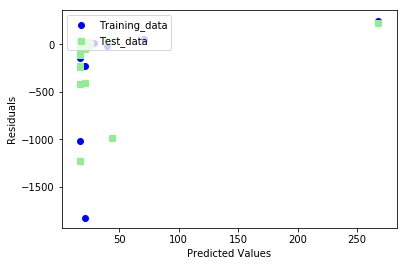

In [20]:
RegModelEval(eval_df,n=2000,show=True,training=True,output=output)

In [21]:
#pickle.dump(gs_dt,open('edu_model_v1.pkl','wb'))

In [25]:
#loaded = pickle.load(open('edu_model_v1.pkl', 'rb'))